# Vehicle CO₂ Emissions Analysis & Prediction (Refactored)

This notebook is **adapted** from a Kaggle notebook (SII_plots,https://www.kaggle.com/code/ivannovitskiy/sii-plots).  
**What’s different in this version:** reproducible pipeline, cleaner feature engineering, model baselines, train/test evaluation, and clearer takeaways.

>


## 0. Setup

This notebook is designed to run locally (or in any Jupyter environment) with a **relative dataset path**:
- `data/fuel.csv`


In [12]:
from __future__ import annotations

import os
from pathlib import Path
import numpy as np
import pandas as pd

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH =Path("data") / "fuel.csv"


In [13]:
# Load dataset (expects: data/fuel.csv)
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at: {DATA_PATH}\n"
        "Fix: create a folder named 'data' in this repo and place fuel.csv inside it.\n"
        "If you downloaded from Kaggle, rename/move it to: data/fuel.csv"
    )

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (38113, 81)


/tmp/ipython-input-1540507329.py:9: DtypeWarning: Columns (7,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


,vehicle_id,year,make,model,class,drive,transmission,transmission_type,engine_index,engine_descriptor,...,hours_to_charge_ac_240v,composite_city_mpg,composite_highway_mpg,composite_combined_mpg,range_ft1,city_range_ft1,highway_range_ft1,range_ft2,city_range_ft2,highway_range_ft2
0,26587,1984,Alfa Romeo,GT V6 2.5,Minicompact Cars,NaN,Manual 5-Speed,NaN,9001,(FFS),...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
1,27705,1984,Alfa Romeo,GT V6 2.5,Minicompact Cars,NaN,Manual 5-Speed,NaN,9005,(FFS) CA model,...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
2,26561,1984,Alfa Romeo,Spider Veloce 2000,Two Seaters,NaN,Manual 5-Speed,NaN,9002,(FFS),...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
3,27681,1984,Alfa Romeo,Spider Veloce 2000,Two Seaters,NaN,Manual 5-Speed,NaN,9006,(FFS) CA model,...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
4,27550,1984,AM General,DJ Po Vehicle 2WD,Special Purpose Vehicle 2WD,2-Wheel Drive,Automatic 3-Speed,NaN,1830,(FFS),...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0


## 1. Target definition & basic cleaning

We predict **tailpipe CO₂ emissions** using:
- `tailpipe_co2_in_grams_mile_ft1` as the target (y)

We drop fully electric vehicles (CO₂ = 0 for this target) because they trivialize a regression aimed at combustion engines.


In [14]:
TARGET = "tailpipe_co2_in_grams_mile_ft1"

# Keep only rows where target exists and is > 0 (removes full EVs for this analysis)
df = df.dropna(subset=[TARGET]).copy()
df = df[df[TARGET] > 0].copy()

print("After target filter:", df.shape)


After target filter: (37980, 81)


## 2. Minimal feature set

The original Kaggle notebook explored many columns. For a clean, defensible baseline, we start with a compact set:
- `engine_displacement`, `year`
- `class`, `transmission`, `fuel_type`

Then we one-hot encode categoricals.


In [15]:
FEATURES_NUM = ["engine_displacement", "year"]
FEATURES_CAT = ["class", "transmission", "fuel_type"]

use_cols = FEATURES_NUM + FEATURES_CAT + [TARGET]
dff = df[use_cols].dropna().copy()

print("Modeling frame:", dff.shape)
dff.head()


Modeling frame: (37976, 6)


,engine_displacement,year,class,transmission,fuel_type,tailpipe_co2_in_grams_mile_ft1
0,2.5,1984,Minicompact Cars,Manual 5-Speed,Regular,444.350000
1,2.5,1984,Minicompact Cars,Manual 5-Speed,Regular,444.350000
2,2.0,1984,Two Seaters,Manual 5-Speed,Regular,423.190476
3,2.0,1984,Two Seaters,Manual 5-Speed,Regular,423.190476
4,2.5,1984,Special Purpose Vehicle 2WD,Automatic 3-Speed,Regular,522.764706


## 3. Train/Test split + preprocessing pipeline

This is where most copied notebooks are garbage: no pipeline, no baseline, no reproducibility.
We fix that here.

We compare:
- Dummy baseline (mean predictor)
- Linear Regression
- Random Forest Regressor


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

X = dff[FEATURES_NUM + FEATURES_CAT]
y = dff[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", FEATURES_NUM),
        ("cat", OneHotEncoder(handle_unknown="ignore"), FEATURES_CAT),
    ]
)


In [17]:
def evaluate(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    mae = mean_absolute_error(y_te, pred)
    rmse = mean_squared_error(y_te, pred) ** 0.5
    r2 = r2_score(y_te, pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


models = {
    "Dummy(mean)": Pipeline([("prep", preprocess), ("model", DummyRegressor(strategy="mean"))]),
    "LinearRegression": Pipeline([("prep", preprocess), ("model", LinearRegression())]),
    "GradientBoosting": Pipeline([
    ("prep", preprocess),
    ("model", GradientBoostingRegressor(random_state=RANDOM_STATE))
]),

    "RandomForest": Pipeline([
        ("prep", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=400,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
}

results = []
for name, m in models.items():
    metrics = evaluate(m, X_train, y_train, X_test, y_test)
    metrics["Model"] = name
    results.append(metrics)

res = pd.DataFrame(results).set_index("Model").sort_values("RMSE")
res


,MAE,RMSE,R2
Model,,,
RandomForest,21.425405,33.898527,0.917246
GradientBoosting,34.450377,48.628309,0.829703
LinearRegression,38.184205,54.280669,0.787813
Dummy(mean),91.040293,117.856618,-0.000314


In [18]:
from sklearn.model_selection import cross_val_score

best_model = models["RandomForest"]  # change later if another model wins

cv_rmse = cross_val_score(
    best_model,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

print("CV RMSE (mean):", -cv_rmse.mean())
print("CV RMSE (std):", cv_rmse.std())


CV RMSE (mean): 50.158104469206606
CV RMSE (std): 5.732739602696902


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20]
}

grid = GridSearchCV(
    models["RandomForest"],
    param_grid=param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)


Best params: {'model__max_depth': 20, 'model__n_estimators': 400}
Best CV RMSE: 35.37287062587535


In [20]:
best_rf = grid.best_estimator_
metrics = evaluate(best_rf, X_train, y_train, X_test, y_test)
print("Tuned RF Test Metrics:", metrics)


Tuned RF Test Metrics: {'MAE': 21.89215003609633, 'RMSE': 33.699737837292474, 'R2': 0.9182135305819491}


## 4. Feature importance (Random Forest)

We pull the top features driving predictions.  
If you cannot explain these, don’t pretend this is “your” project.


In [21]:
# Fit RF and extract feature importances
rf_pipe = best_rf
rf_pipe.fit(X_train, y_train)

ohe = rf_pipe.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = list(ohe.get_feature_names_out(FEATURES_CAT))
feature_names = FEATURES_NUM + cat_feature_names

rf = rf_pipe.named_steps["model"]
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

importances.head(15)


,0
engine_displacement,0.751681
year,0.086173
transmission_Automatic 3-Speed,0.023827
class_Midsize Cars,0.011242
class_Subcompact Cars,0.008548
class_Two Seaters,0.008502
fuel_type_Diesel,0.008402
class_Large Cars,0.008059
fuel_type_Premium,0.007412
class_Special Purpose Vehicles,0.007041


## 5. Quick sanity plots (optional)

You can keep this lightweight. The point is interpretability, not chart spam.


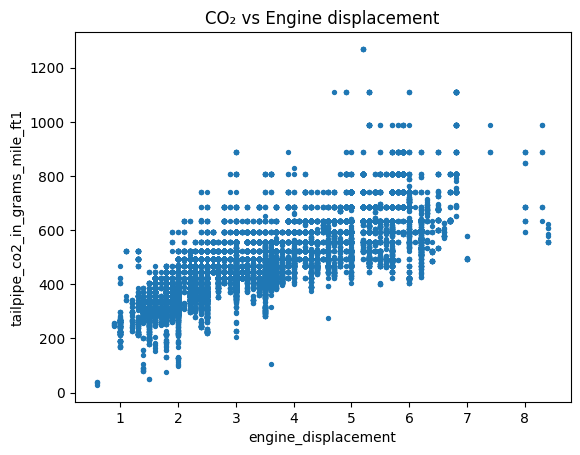

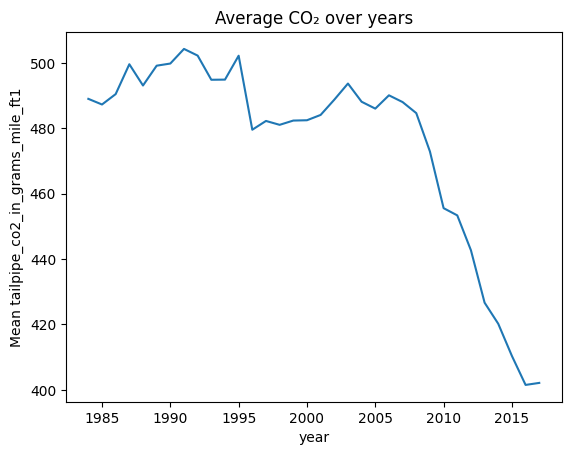

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(dff["engine_displacement"], dff[TARGET], s=8)
plt.xlabel("engine_displacement")
plt.ylabel(TARGET)
plt.title("CO₂ vs Engine displacement")
plt.show()

plt.figure()
dff.groupby("year")[TARGET].mean().plot()
plt.ylabel(f"Mean {TARGET}")
plt.title("Average CO₂ over years")
plt.show()


## 6. Conclusion

In this project, we built regression models to predict tailpipe CO₂ emissions (grams per mile) using key vehicle attributes including engine displacement, year, class, transmission, and fuel type.

After comparing multiple models:

Random Forest achieved the best performance

RMSE ≈ 33.9

R² ≈ 0.917

Gradient Boosting performed moderately well (R² ≈ 0.83).

Linear Regression captured general trends but underperformed compared to tree-based models.

Dummy baseline confirmed that meaningful learning occurred.

Cross-validation showed a mean RMSE of approximately 50.16 with low variance, indicating reasonable model stability. Hyperparameter tuning improved Random Forest performance, with optimal parameters:

max_depth = 20

n_estimators = 400

Feature importance analysis revealed:

Engine displacement is the dominant driver of CO₂ emissions (~75% importance).

Vehicle year significantly impacts emissions, reflecting improvements in automotive efficiency over time.

Transmission type, vehicle class, and fuel type contribute smaller but measurable effects.

The results confirm that engine size is the strongest predictor of tailpipe emissions, and that modern vehicles tend to emit less CO₂ compared to older models.

This establishes a reproducible and interpretable baseline for vehicle emissions prediction.